# lab 5: translation simple ecoder-decocer over the b2 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot, plot_confusion_matrix
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

### Preparing data

In [3]:
df2 = pd.read_csv("data/boolean2_train.csv")
df2_test = pd.read_csv("data/boolean2_test.csv")

df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [4]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Agnes is proud and Lauren is ambitious,Agnes is not proud,Agnes is proud,Lauren is ambitious,1,Agnes is proud and Lauren is ambitious Agnes i...
8496,Curtis is wonderful and Jessie is ambitious,Curtis is not wonderful,Curtis is wonderful,Jessie is ambitious,1,Curtis is wonderful and Jessie is ambitious Cu...
8497,Brett is dead and Tracy is important,Tracy is not important,Brett is dead,Tracy is important,1,Brett is dead and Tracy is important Tracy is ...
8498,Lauren is hallowed and Yvette is shy,Yvette is not shy,Lauren is hallowed,Yvette is shy,1,Lauren is hallowed and Yvette is shy Yvette is...
8499,Kathleen is alive and Dustin is clever,Dustin is not clever,Kathleen is alive,Dustin is clever,1,Kathleen is alive and Dustin is clever Dustin ...


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [7]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [8]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [9]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
MAX_LENGTH = 20


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [11]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [12]:
_, _, training_pairs_A = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

print()
_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 705
eng_dec 704

Read 11000 sentence pairs
Trimmed to 11000 sentence pairs
Counting words...
Counted words:
eng_enc 706
eng_dec 706


Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 696
eng_dec 644


In [13]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 705
eng_dec 704

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 696
eng_dec 638


### sentences 2 tensors

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [15]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [16]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [17]:
def tensorsFromTriple(triple):
    input_tensor = tensorFromSentence(input_lang, triple[0])
    target_tensor = tensorFromSentence(output_lang, triple[1])
    label_tensor = torch.tensor(triple[2], dtype=torch.long).view((1))
    return (input_tensor, target_tensor, label_tensor)

### models

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
hidden_size = 100
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [39]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = DecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("encoder4.pkl"))
decoderA.load_state_dict(torch.load("decoder4.pkl"))

In [40]:
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = DecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("encoder5.pkl"))
decoderB.load_state_dict(torch.load("decoder5.pkl"))

## translating

In [23]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a trained model: and A

In [24]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderA,
                                   decoderA,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : penny is thankful and naomi is alive
neural translation : blanche is thankful <EOS>
reference translation : penny is thankful <EOS>
blue score = 0.71

input_sentence : carlos is kind and paula is uninterested
neural translation : carlos is kind <EOS>
reference translation : carlos is kind <EOS>
blue score = 1.00

input_sentence : jack is hallowed and kent is easy
neural translation : jack is hallowed <EOS>
reference translation : jack is hallowed <EOS>
blue score = 1.00



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## translation of a trained model: and B

In [25]:
for t in training_pairs_B[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderB,
                                   decoderB,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : penny is thankful and naomi is alive
neural translation : naomi is alive <EOS>
reference translation : naomi is alive <EOS>
blue score = 1.00

input_sentence : carlos is kind and paula is uninterested
neural translation : paula is uninterested <EOS>
reference translation : paula is uninterested <EOS>
blue score = 1.00

input_sentence : jack is hallowed and kent is easy
neural translation : kent is easy <EOS>
reference translation : kent is easy <EOS>
blue score = 1.00



## Defining the And model

model inner working:

- $s_1$ is the first sentence (e.g., 'penny is thankful and naomi is alive')

- $s_2$ is the second sentence (e.g., 'penny is not alive')

- $h_A = dec_{A}(enc_{A}(s_1, \vec{0}))$

- $h_B = dec_{B}(enc_{B}(s_1, \vec{0}))$

- $h_{inf} = h_A + h_B$

- $e = enc_{A}(s_2, h_{inf})$

- $\hat{y} = softmax(We + b)$

In [26]:
class AndModel(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModel, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
            
        
        for ei in range(input_length):
            _, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)
        h_inf = hA + hB
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [41]:
addmodel = AndModel(encoderA,
                    decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

Test encoding decoding

In [42]:
for ex in training_pairs_B[0:3]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    
    ex_A = addmodel.sen2vec(ex,
                     addmodel.encoderA,
                     addmodel.decoderA,
                     is_tensor=False,
                     out_tensor=False)
    
    ex_B = addmodel.sen2vec(ex,
                     addmodel.encoderB,
                     addmodel.decoderB,
                     is_tensor=False,
                     out_tensor=False)

    print("inference A:\n")
    print(ex_A)
    print()
    print("inference B:\n")
    print(ex_B)

s1:

penny is thankful and naomi is alive

inference A:

blanche is thankful <EOS>

inference B:

naomi is alive <EOS>
s1:

carlos is kind and paula is uninterested

inference A:

carlos is kind <EOS>

inference B:

paula is uninterested <EOS>
s1:

jack is hallowed and kent is easy

inference A:

jack is hallowed <EOS>

inference B:

kent is easy <EOS>


In [29]:
for ex in training_pairs_B[0:1]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    ex_A = addmodel.sen2vecA(ex,is_tensor=False)
    ex_B = addmodel.sen2vecB(ex,is_tensor=False)
    
    print(ex_A)
    print()
    print(ex_B)

s1:

penny is thankful and naomi is alive

tensor([[[-0.4259, -0.5321,  0.6835,  0.9980,  0.9865, -0.0326, -0.8547,
          -0.6571,  0.5157,  0.0794,  0.4141, -0.3890,  1.0000, -0.9051,
           0.9944,  0.9096,  0.0875, -0.9996,  0.9112, -0.0006, -0.9984,
          -0.7040, -0.0880, -0.7222, -0.9990,  0.7732, -0.9064,  0.2055,
           0.1898,  0.8505, -0.6891, -0.9391,  0.9999, -0.9916,  0.5694,
           0.3941,  0.8801,  0.9980, -0.5498, -0.8040, -0.1095, -0.2328,
          -0.9724,  0.8991, -0.2609, -0.0054,  0.9327, -0.9945, -0.1388,
          -0.9704, -0.9887,  0.9991,  0.8406,  0.0321, -0.9388, -0.6922,
           0.0622, -0.9972, -0.9954,  0.8046, -0.4433,  0.9741, -0.8358,
          -0.9171, -0.9966, -0.4546,  0.9799, -0.1956,  0.9755, -0.5717,
          -0.6437, -0.4731, -0.7418,  0.9960, -0.9396,  0.0081,  0.4872,
          -0.9808, -0.2468,  0.7522,  0.2154,  0.9563,  0.9638,  0.5954,
           0.8221, -0.0410,  0.8202, -0.9973,  0.4164, -0.1902, -0.9980,
        

In [30]:
train_triples = zip(list(df2train.sentence1.values), list(df2train.sentence2.values), list(df2train.label.values))
train_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in train_triples]
train_triples_t = [tensorsFromTriple(t) for t in train_triples]


example = train_triples[0]
print(example)
example_t = train_triples_t[0]
print(example_t)

('penny is thankful and naomi is alive', 'penny is not alive', 0)
(tensor([[2],
        [3],
        [4],
        [5],
        [6],
        [3],
        [7],
        [1]]), tensor([[2],
        [3],
        [8],
        [7],
        [1]]), tensor([0]))


## Prediction BEFORE training

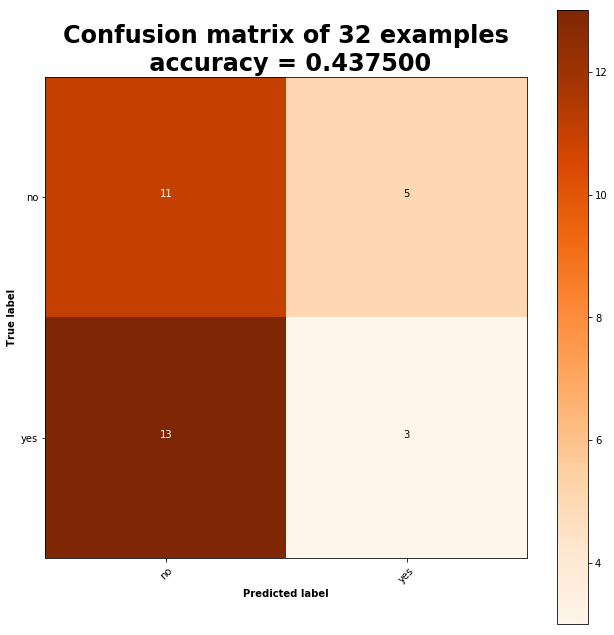

In [31]:
n_iters = 32
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

### Training functions

In [32]:
def CEtrain(s1_tensor,
            s2_tensor,
            label,
            model,
            optimizer,
            criterion):
    
    model.train()
    optimizer.zero_grad()
    logits = model(s1_tensor, s2_tensor)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()
    return loss

Test CEtrain

In [33]:
CE = nn.CrossEntropyLoss()
addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= 0.3)

loss = CEtrain(s1_tensor=example_t[0],
               s2_tensor=example_t[1],
               label=example_t[2],
               model=addmodel,
               optimizer=addmodel_opt,
               criterion=CE)
assert type(loss.item()) == float 

## Little example of training

epoch 1/13 0m 21s mean loss = 2.34
epoch 2/13 0m 22s mean loss = 2.75
epoch 3/13 0m 22s mean loss = 2.86
epoch 4/13 0m 25s mean loss = 2.96
epoch 5/13 0m 23s mean loss = 3.12
epoch 6/13 0m 24s mean loss = 3.28
epoch 7/13 0m 28s mean loss = 3.06
epoch 8/13 0m 28s mean loss = 3.57
epoch 9/13 0m 29s mean loss = 3.47
epoch 10/13 0m 31s mean loss = 3.04
epoch 11/13 0m 31s mean loss = 3.07
epoch 12/13 0m 28s mean loss = 2.98
epoch 13/13 0m 30s mean loss = 3.35


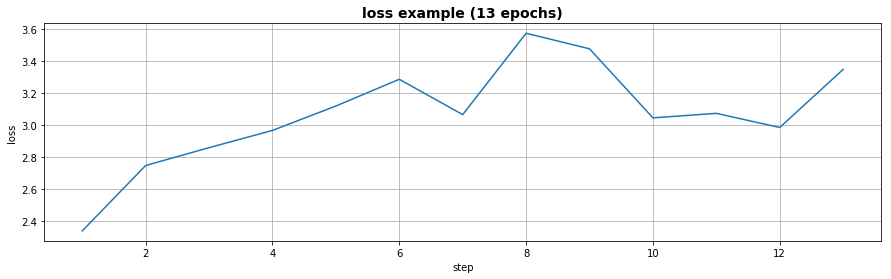

In [34]:
epochs = 13
learning_rate = 0.09

CE = nn.CrossEntropyLoss()


addmodel = AndModel(encoderA,
                    decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)
addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= learning_rate)


losses_per_epoch = []

for i in range(epochs):
    losses = []
    start = time.time()
    n_iters = 1000
    training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
    for t in training_pairs_little:
        s1, s2, label = t    
        loss = CEtrain(s1_tensor=s1,
                       s2_tensor=s2,
                       label=label,
                       model=addmodel,
                       optimizer=addmodel_opt,
                       criterion=CE)
        losses.append(loss.item())
    mean_loss = np.mean(losses)
    losses_per_epoch.append(mean_loss)
    print("epoch {}/{}".format(i+1, epochs), timeSince(start), "mean loss = {:.2f}".format(mean_loss))

simple_step_plot([losses_per_epoch],
                 "loss",
                 "loss example ({} epochs)".format(epochs),
                 "loss_example.png",
                  figsize=(15,4))

## Prediction AFTER training

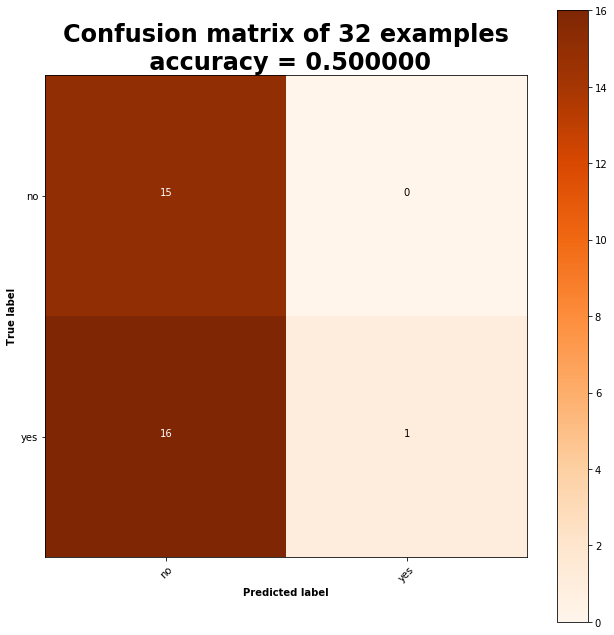

In [35]:
n_iters = 32
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")